In [1]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, linewidth=120)

In [2]:
#!pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 107 kB 366 kB/s eta 0:00:01


In [3]:
from pandas_datareader.data import DataReader

# Get the datasets from FRED
start = '1979-01-01'
end = '2014-12-01'
indprod = DataReader('IPMAN', 'fred', start=start, end=end)
income = DataReader('W875RX1', 'fred', start=start, end=end)
sales = DataReader('CMRMTSPL', 'fred', start=start, end=end)
emp = DataReader('PAYEMS', 'fred', start=start, end=end)
# dta = pd.concat((indprod, income, sales, emp), axis=1)
# dta.columns = ['indprod', 'income', 'sales', 'emp']

/home/ekim_reverse/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
income

,W875RX1
DATE,
1979-01-01,4952.2
1979-02-01,4980.5
1979-03-01,4995.5
1979-04-01,4946.8
1979-05-01,4932.3
...,...
2014-08-01,12179.2
2014-09-01,12222.6
2014-10-01,12281.3


In [5]:
indprod

,IPMAN
DATE,
1979-01-01,48.1248
1979-02-01,48.2899
1979-03-01,48.5268
1979-04-01,47.7418
1979-05-01,48.3654
...,...
2014-08-01,102.6082
2014-09-01,102.6413
2014-10-01,102.5636


In [6]:
sales

,CMRMTSPL
DATE,
1979-01-01,593005.073
1979-02-01,590202.467
1979-03-01,607282.118
1979-04-01,590898.041
1979-05-01,603979.409
...,...
2014-08-01,1366998.000
2014-09-01,1366811.000
2014-10-01,1368570.000


In [7]:
emp

,PAYEMS
DATE,
1979-01-01,88808
1979-02-01,89055
1979-03-01,89479
1979-04-01,89417
1979-05-01,89789
...,...
2014-08-01,139257
2014-09-01,139566
2014-10-01,139818


In [8]:
# HMRMT = DataReader('HMRMT', 'fred', start='1967-01-01', end=end)
# CMRMT = DataReader('CMRMT', 'fred', start='1997-01-01', end=end)

In [9]:
# HMRMT_growth = HMRMT.diff() / HMRMT.shift()
# sales = pd.Series(np.zeros(emp.shape[0]), index=emp.index)

# # Fill in the recent entries (1997 onwards)
# sales[CMRMT.index] = CMRMT

# # Backfill the previous entries (pre 1997)
# idx = sales.loc[:'1997-01-01'].index
# for t in range(len(idx)-1, 0, -1):
#     month = idx[t]
#     prev_month = idx[t-1]
#     sales.loc[prev_month] = sales.loc[month] / (1 + HMRMT_growth.loc[prev_month].values)

In [10]:
dta = pd.concat((indprod, income, sales, emp), axis=1)
dta.columns = ['indprod', 'income', 'sales', 'emp']

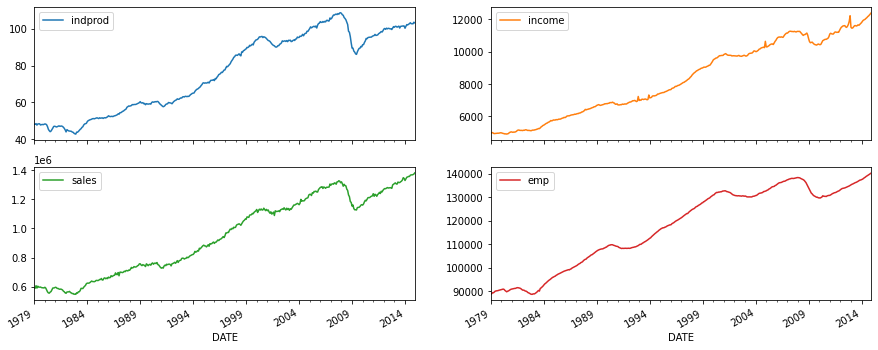

In [11]:
dta.loc[:, 'indprod':'emp'].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

In [12]:
# Create log-differenced series
dta['dln_indprod'] = (np.log(dta.indprod)).diff() * 100
dta['dln_income'] = (np.log(dta.income)).diff() * 100
dta['dln_sales'] = (np.log(dta.sales)).diff() * 100
dta['dln_emp'] = (np.log(dta.emp)).diff() * 100

# De-mean and standardize
dta['std_indprod'] = (dta['dln_indprod'] - dta['dln_indprod'].mean()) / dta['dln_indprod'].std()
dta['std_income'] = (dta['dln_income'] - dta['dln_income'].mean()) / dta['dln_income'].std()
dta['std_sales'] = (dta['dln_sales'] - dta['dln_sales'].mean()) / dta['dln_sales'].std()
dta['std_emp'] = (dta['dln_emp'] - dta['dln_emp'].mean()) / dta['dln_emp'].std()

In [14]:
# Get the endogenous data
endog = dta.loc['1979-02-01':, 'std_indprod':'std_emp']

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)

/home/ekim_reverse/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ekim_reverse/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
print(res.summary(separate_params=False))

                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  431
Model:                                 DynamicFactor(factors=1, order=2)   Log Likelihood               -2065.023
                                                          + AR(2) errors   AIC                           4166.045
Date:                                                   Thu, 21 May 2020   BIC                           4239.235
Time:                                                           13:44:10   HQIC                          4194.943
Sample:                                                       02-01-1979                                         
                                                            - 12-01-2014                                         
Covariance Type:                                                     opg                

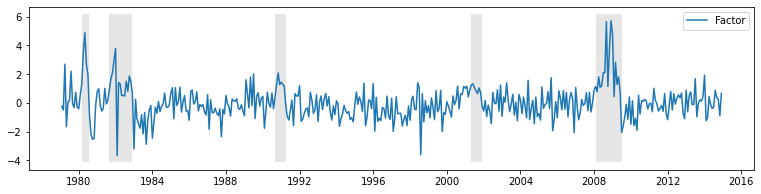

In [17]:
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

# Retrieve and also plot the NBER recession indicators
rec = DataReader('USREC', 'fred', start=start, end=end)
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4,0], facecolor='k', alpha=0.1);

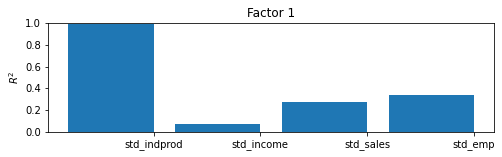

In [18]:
res.plot_coefficients_of_determination(figsize=(8,2));

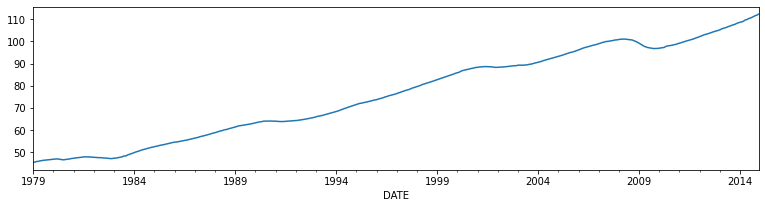

In [19]:
usphci = DataReader('USPHCI', 'fred', start='1979-01-01', end='2014-12-01')['USPHCI']
usphci.plot(figsize=(13,3));

In [20]:
dusphci = usphci.diff()[1:].values
def compute_coincident_index(mod, res):
    # Estimate W(1)
    spec = res.specification
    design = mod.ssm['design']
    transition = mod.ssm['transition']
    ss_kalman_gain = res.filter_results.kalman_gain[:,:,-1]
    k_states = ss_kalman_gain.shape[0]

    W1 = np.linalg.inv(np.eye(k_states) - np.dot(
        np.eye(k_states) - np.dot(ss_kalman_gain, design),
        transition
    )).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = np.dot(W1, dta.loc['1972-02-01':, 'dln_indprod':'dln_emp'].mean())

    # Normalize the factors
    factor = res.factors.filtered[0]
    factor *= np.std(usphci.diff()[1:]) / np.std(factor)

    # Compute the coincident index
    coincident_index = np.zeros(mod.nobs+1)
    # The initial value is arbitrary; here it is set to
    # facilitate comparison
    coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    for t in range(0, mod.nobs):
        coincident_index[t+1] = coincident_index[t] + factor[t] + factor_mean

    # Attach dates
    coincident_index = pd.Series(coincident_index, index=dta.index).iloc[1:]

    # Normalize to use the same base year as USPHCI
    coincident_index *= (usphci.loc['1992-07-01'] / coincident_index.loc['1992-07-01'])

    return coincident_index

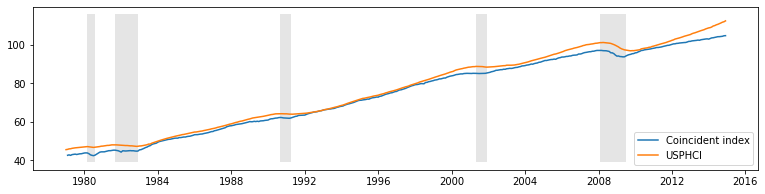

In [21]:
fig, ax = plt.subplots(figsize=(13,3))

# Compute the index
coincident_index = compute_coincident_index(mod, res)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index, label='Coincident index')
ax.plot(usphci.index._mpl_repr(), usphci, label='USPHCI')
ax.legend(loc='lower right')

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4,0], facecolor='k', alpha=0.1);

In [22]:
from statsmodels.tsa.statespace import tools
class ExtendedDFM(sm.tsa.DynamicFactor):
    def __init__(self, endog, **kwargs):
            # Setup the model as if we had a factor order of 4
            super(ExtendedDFM, self).__init__(
                endog, k_factors=1, factor_order=4, error_order=2,
                **kwargs)

            # Note: `self.parameters` is an ordered dict with the
            # keys corresponding to parameter types, and the values
            # the number of parameters of that type.
            # Add the new parameters
            self.parameters['new_loadings'] = 3

            # Cache a slice for the location of the 4 factor AR
            # parameters (a_1, ..., a_4) in the full parameter vector
            offset = (self.parameters['factor_loadings'] +
                      self.parameters['exog'] +
                      self.parameters['error_cov'])
            self._params_factor_ar = np.s_[offset:offset+2]
            self._params_factor_zero = np.s_[offset+2:offset+4]

    @property
    def start_params(self):
        # Add three new loading parameters to the end of the parameter
        # vector, initialized to zeros (for simplicity; they could
        # be initialized any way you like)
        return np.r_[super(ExtendedDFM, self).start_params, 0, 0, 0]

    @property
    def param_names(self):
        # Add the corresponding names for the new loading parameters
        #  (the name can be anything you like)
        return super(ExtendedDFM, self).param_names + [
            'loading.L%d.f1.%s' % (i, self.endog_names[3]) for i in range(1,4)]

    def transform_params(self, unconstrained):
            # Perform the typical DFM transformation (w/o the new parameters)
            constrained = super(ExtendedDFM, self).transform_params(
            unconstrained[:-3])

            # Redo the factor AR constraint, since we only want an AR(2),
            # and the previous constraint was for an AR(4)
            ar_params = unconstrained[self._params_factor_ar]
            constrained[self._params_factor_ar] = (
                tools.constrain_stationary_univariate(ar_params))

            # Return all the parameters
            return np.r_[constrained, unconstrained[-3:]]

    def untransform_params(self, constrained):
            # Perform the typical DFM untransformation (w/o the new parameters)
            unconstrained = super(ExtendedDFM, self).untransform_params(
                constrained[:-3])

            # Redo the factor AR unconstrained, since we only want an AR(2),
            # and the previous unconstrained was for an AR(4)
            ar_params = constrained[self._params_factor_ar]
            unconstrained[self._params_factor_ar] = (
                tools.unconstrain_stationary_univariate(ar_params))

            # Return all the parameters
            return np.r_[unconstrained, constrained[-3:]]

    def update(self, params, transformed=True, **kwargs):
        # Peform the transformation, if required
        if not transformed:
            params = self.transform_params(params)
        params[self._params_factor_zero] = 0

        # Now perform the usual DFM update, but exclude our new parameters
        super(ExtendedDFM, self).update(params[:-3], transformed=True, **kwargs)

        # Finally, set our new parameters in the design matrix
        self.ssm['design', 3, 1:4] = params[-3:]

In [23]:
# Create the model
extended_mod = ExtendedDFM(endog)
initial_extended_res = extended_mod.fit(maxiter=1000, disp=False)
extended_res = extended_mod.fit(initial_extended_res.params, method='nm', maxiter=1000)
print(extended_res.summary(separate_params=False))

/home/ekim_reverse/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 4.698612
         Iterations: 278
         Function evaluations: 469
                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  431
Model:                                 DynamicFactor(factors=1, order=4)   Log Likelihood               -2025.102
                                                          + AR(2) errors   AIC                           4096.203
Date:                                                   Thu, 21 May 2020   BIC                           4189.724
Time:                                                           13:45:30   HQIC                          4133.128
Sample:                                                       02-01-1979                                         
                                                            - 

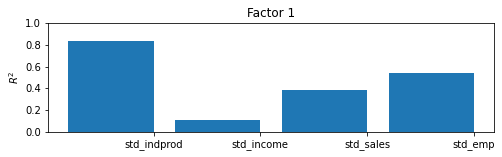

In [24]:
extended_res.plot_coefficients_of_determination(figsize=(8,2));

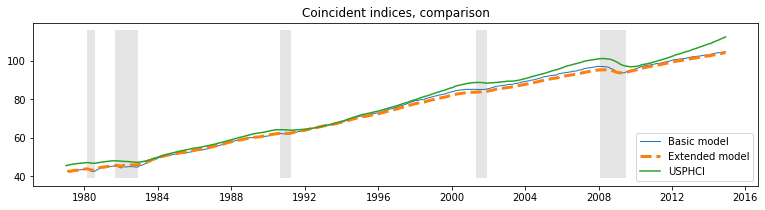

In [25]:
fig, ax = plt.subplots(figsize=(13,3))

# Compute the index
extended_coincident_index = compute_coincident_index(extended_mod, extended_res)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index, '-', linewidth=1, label='Basic model')
ax.plot(dates, extended_coincident_index, '--', linewidth=3, label='Extended model')
ax.plot(usphci.index._mpl_repr(), usphci, label='USPHCI')
ax.legend(loc='lower right')
ax.set(title='Coincident indices, comparison')

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4,0], facecolor='k', alpha=0.1);
